In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
from pyarrow.parquet import ParquetFile, ParquetWriter
#from typing import Optional

import numpy as np
import gc
from numpy.typing import NDArray
import numba
import math

try:
	from tqdm.notebook import tqdm	# prettier in Jupyter
except Exception:
	from tqdm.auto import tqdm		# fallback


from IPython.core.interactiveshell import InteractiveShell


from tpx3awkward._utils import (
    drop_zero_tot,
    cluster_df_optimized,
    group_indices,
    centroid_clusters,
    ingest_cent_data,
    add_centroid_cols,
    trim_corr_file,
    trim_corr,
    timewalk_corr,
    DEFAULT_CLUSTER_TW,
    DEFAULT_CLUSTER_RADIUS,
    raw_as_numpy,
	 ingest_raw_data,
	is_packet_header,
        matches_nibble,
        get_block,
		  decode_message,
)


InteractiveShell.ast_node_interactivity = "all"  # ustaw raz w notatniku

In [20]:
DEFAULT_CLUSTER_RADIUS = 3
DEFAULT_CLUSTER_TW = int(0.3e-6 / 1.5625e-9)  # reuse your constant
DEFAULT_CLUSTER_TW


@numba.njit(cache=True)
def cluster_events(events: np.ndarray, radius: int, tw: int):
	# events: (N,4) -> x,y,ToT,t
	n = events.shape[0]
	labels = np.full(n, -1, np.int64)
	cluster_id = 0
	r2 = radius * radius
	for i in range(n):
		if labels[i] != -1:
			continue
		labels[i] = cluster_id
		t_i = events[i, 3]
		x_i = events[i, 0]
		y_i = events[i, 1]
		for j in range(i + 1, n):
			# early exit on time window
			if events[j, 3] - t_i > tw:
				break
			dx = x_i - events[j, 0]
			dy = y_i - events[j, 1]
			if dx * dx + dy * dy <= r2:
				labels[j] = cluster_id
		cluster_id += 1
	return labels


def cluster_df_corrected(df: pd.DataFrame, tw=DEFAULT_CLUSTER_TW, radius=DEFAULT_CLUSTER_RADIUS):
	df_sorted = df.sort_values("t", kind="mergesort").reset_index(drop=True)
	events = df_sorted[["x", "y", "ToT", "t"]].to_numpy()
	labels = cluster_events(events, radius, tw)
	return labels, events


@numba.njit(cache=True)
def group_indices(labels: np.ndarray):
	n_clusters = labels.max() + 1
	counts = np.zeros(n_clusters, np.int32)
	for lab in labels:
		counts[lab] += 1
	max_size = counts.max()
	out = -1 * np.ones((n_clusters, max_size), dtype=np.int32)
	fill = np.zeros(n_clusters, np.int32)
	for i in range(labels.size):
		c = labels[i]
		pos = fill[c]
		out[c, pos] = i
		fill[c] += 1
	return out


@numba.njit(cache=True)
def centroid_clusters(cluster_arr: np.ndarray, events: np.ndarray):
	n_clusters = cluster_arr.shape[0]
	max_cluster = cluster_arr.shape[1]
	t = np.zeros(n_clusters, dtype=np.uint64)
	xc = np.zeros(n_clusters, dtype=np.float32)
	yc = np.zeros(n_clusters, dtype=np.float32)
	ToT_max = np.zeros(n_clusters, dtype=np.uint32)
	ToT_sum = np.zeros(n_clusters, dtype=np.uint32)
	n = np.zeros(n_clusters, dtype=np.uint8)
	for cid in range(n_clusters):
		local_max = np.uint32(0)
		for k in range(max_cluster):
			ei = cluster_arr[cid, k]
			if ei < 0:
				break
			x = events[ei, 0]
			y = events[ei, 1]
			tot = np.uint32(events[ei, 2])
			ts = events[ei, 3]
			if tot > local_max:
				local_max = tot
				ToT_max[cid] = tot
				t[cid] = ts
			xc[cid] += x * tot
			yc[cid] += y * tot
			ToT_sum[cid] += tot
			n[cid] += 1
		if ToT_sum[cid] > 0:
			xc[cid] /= ToT_sum[cid]
			yc[cid] /= ToT_sum[cid]
	return t, xc, yc, ToT_max, ToT_sum, n


def add_centroid_cols(df: pd.DataFrame, gap=False):
	if gap:
		df.loc[df["xc"] >= 255.5, "xc"] += 2
		df.loc[df["yc"] >= 255.5, "yc"] += 2
	df["x"] = np.round(df["xc"]).astype(np.uint16)
	df["y"] = np.round(df["yc"]).astype(np.uint16)
	df["t_ns"] = df["t"].astype(np.float64) * 1.5625
	return df


def read_uint64_chunks(fpath, chunk_words=5_000_000):
	fpath = Path(fpath)
	with fpath.open("rb") as fh:
		while True:
			arr = np.fromfile(fh, dtype="<u8", count=chunk_words)
			if arr.size == 0:
				break
			yield arr


class StreamingDecoder:
	def __init__(self):
		self.heartbeat_lsb = None
		self.heartbeat_msb = None
		self.heartbeat_time = np.uint64(0)
		self.hb_init_flag = False
		self.chip_indx = np.uint8(0)

	def process_chunk(self, words: np.ndarray):
		photons = []
		for msg in words:
			if is_packet_header(msg):
				self.chip_indx = np.uint8(get_block(msg, 8, 32))
			elif matches_nibble(msg, 0xB):
				x, y, ToT, t = decode_message(msg, self.chip_indx, heartbeat_time=self.heartbeat_time)
				photons.append((t, x, y, ToT, self.chip_indx))
			elif matches_nibble(msg, 0x4):
				sub = (msg >> np.uint64(56)) & np.uint64(0x0F)
				if sub == 0x4:
					self.heartbeat_lsb = (msg >> np.uint64(16)) & np.uint64(0xFFFFFFFF)
				elif sub == 0x5 and self.heartbeat_lsb is not None:
					self.heartbeat_msb = ((msg >> np.uint64(16)) & np.uint64(0xFFFF)) << np.uint64(32)
					self.heartbeat_time = self.heartbeat_msb | self.heartbeat_lsb
		return photons


def flush_cluster_centroid(df_raw_batch, tw=DEFAULT_CLUSTER_TW, radius=DEFAULT_CLUSTER_RADIUS, gap_corr=False):
	if df_raw_batch.empty:
		# Return empty raw and centroid dfs
		return df_raw_batch, pd.DataFrame(columns=["t", "xc", "yc", "ToT_max", "ToT_sum", "n"])
	df = drop_zero_tot(df_raw_batch)
	labels, events = cluster_df_optimized(df, tw=tw, radius=radius)
	df["cluster_id"] = labels
	cluster_array = group_indices(labels)
	cent_tuple = centroid_clusters(cluster_array, events)
	cent_df = pd.DataFrame(ingest_cent_data(cent_tuple)).sort_values("t").reset_index(drop=True)
	cent_df = add_centroid_cols(cent_df, gap=gap_corr)  # was gap=True
	return df, cent_df


def stream_process_file(
		fpath,
		out_raw="raw_big.parquet",
		out_cent="cent_big.parquet",
		chunk_words=5_000_000,
		number_of_chunks: int = None,
		flush_after=2_500_000,
		overlap_ticks=300_000,
		tw=DEFAULT_CLUSTER_TW,
		radius=DEFAULT_CLUSTER_RADIUS,
		gap_corr=False,  # new parameter
):
	"""
	Streaming decode + clustering with incremental (append) parquet writes.
	Fixes previous behavior that overwrote the parquet at every flush.
	"""
	raw_out = Path(out_raw)
	cent_out = Path(out_cent)

	# Start clean
	if raw_out.exists():
		raw_out.unlink()
	if cent_out.exists():
		cent_out.unlink()

	decoder = StreamingDecoder()
	buffer = []
	max_t = 0

	# For incremental parquet writing
	raw_writer = None
	cent_writer = None

	fsize = Path(fpath).stat().st_size
	est_chunks = math.ceil(fsize / (chunk_words * 8)) or None

	if number_of_chunks:
		est_chunks = min(number_of_chunks, est_chunks)

	photons_total = 0
	pbar = tqdm(
		read_uint64_chunks(fpath, chunk_words=chunk_words),
		total=est_chunks,
		desc="Streaming decode",
		unit="chunk"
	)

	def write_batch(raw_df: pd.DataFrame, cent_df: pd.DataFrame):
		nonlocal raw_writer, cent_writer
		# Convert once per batch
		raw_table = pa.Table.from_pandas(raw_df, preserve_index=False)
		cent_table = pa.Table.from_pandas(cent_df, preserve_index=False)
		if raw_writer is None:
			raw_writer = ParquetWriter(str(raw_out), raw_table.schema, compression="zstd")
		if cent_writer is None:
			cent_writer = ParquetWriter(str(cent_out), cent_table.schema, compression="zstd")
		raw_writer.write_table(raw_table)
		cent_writer.write_table(cent_table)

	chunks_processed = 0
	for chunk in pbar:
		photons = decoder.process_chunk(chunk)
		if photons:
			buffer.extend(photons)
			photons_total += len(photons)
			mt = max(p[0] for p in photons)
			if mt > max_t:
				max_t = mt

		pbar.set_postfix({"photons": photons_total, "buffer": len(buffer)})

		if len(buffer) >= flush_after:
			buffer.sort(key=lambda r: r[0])
			cutoff = max_t - overlap_ticks
			flush_part = [p for p in buffer if p[0] <= cutoff]
			buffer = [p for p in buffer if p[0] > cutoff]

			if flush_part:
				df_flush = pd.DataFrame(flush_part, columns=["t", "x", "y", "ToT", "chip"])
				raw_df, cent_df = flush_cluster_centroid(df_flush, tw=tw, radius=radius, gap_corr=gap_corr)
				write_batch(raw_df, cent_df)
				del raw_df, cent_df, df_flush, flush_part
				gc.collect()
		chunks_processed += 1
		if chunks_processed >= number_of_chunks:
			break

	# Final flush
	if buffer:
		buffer.sort(key=lambda r: r[0])
		df_final = pd.DataFrame(buffer, columns=["t", "x", "y", "ToT", "chip"])
		raw_df, cent_df = flush_cluster_centroid(df_final, tw=tw, radius=radius, gap_corr=gap_corr)
	else:
		raw_df = pd.DataFrame(columns=["t", "x", "y", "ToT", "chip", "cluster_id"])
		cent_df = pd.DataFrame(columns=["t", "xc", "yc", "ToT_max", "ToT_sum", "n", "x", "y", "t_ns"])

	write_batch(raw_df, cent_df)

	# Close writers
	if raw_writer is not None:
		raw_writer.close()
	if cent_writer is not None:
		cent_writer.close()

	return raw_out, cent_out


192

In [6]:
# data_dir = Path('/home/hades/projects/TimeVaryingDiffuser/Experiment_controll/data_timepix/Measurement_Nov_21_2025_16h20m39s/raw')
# filename_sufix = 'fGKd_000000'

data_dir, filename_sufix="Measurement_Nov_21_2025_16h20m39s","fGKd_000000" #noscatterr
#data_dir, filename_sufix="Measurement_Nov_21_2025_16h23m49s","fGNn_000000" # dynamic
#data_dir, filename_sufix="Measurement_Nov_21_2025_16h31m33s","fGVX_000000" # static

data_dir_path=Path(f'/home/hades/projects/TimeVaryingDiffuser/Experiment_controll/data_timepix/{data_dir}/raw')
fpath = data_dir_path / f'{filename_sufix}.tpx3'

In [4]:
# Run
out_dir= Path('out')
out_dir.mkdir(exist_ok=True, parents=True)
raw_out_path=out_dir / f"{data_dir}_raw_big.parquet2"
cent_out_path=out_dir / f"{data_dir}_cent_big.parquet2"


In [21]:
raw_path, cent_path = stream_process_file(
	fpath=fpath,
	out_raw=raw_out_path,
	out_cent=cent_out_path,
	chunk_words=3_000_000,  # approximate number of rows
	flush_after=1_000_000,
	overlap_ticks=300_000,
	number_of_chunks=None,  #None or number of chunks to be processed
	tw=DEFAULT_CLUSTER_TW,
	radius=DEFAULT_CLUSTER_RADIUS,
	gap_corr=False,  # disable +2 shift
)
print("Raw exists:", raw_path.exists(), "Cent exists:", cent_path.exists())
print("Absolute raw:", raw_path.resolve())
print("Absolute cent:", cent_path.resolve())

Streaming decode:   0%|          | 0/1 [00:00<?, ?chunk/s]

Raw exists: True Cent exists: True
Absolute raw: /home/hades/projects/tpx3awkward/out/Measurement_Nov_21_2025_16h23m49s_raw_big.parquet2
Absolute cent: /home/hades/projects/tpx3awkward/out/Measurement_Nov_21_2025_16h23m49s_cent_big.parquet2


In [14]:
from my_utils import load_and_centroid_to_canvas_subpixel,load_parquet_range

In [22]:
cent_big = load_parquet_range(path=cent_out_path)
cent_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562038 entries, 0 to 562037
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   t        562038 non-null  uint64 
 1   xc       562038 non-null  float32
 2   yc       562038 non-null  float32
 3   ToT_max  562038 non-null  uint32 
 4   ToT_sum  562038 non-null  uint32 
 5   n        562038 non-null  uint8  
 6   x        562038 non-null  uint16 
 7   y        562038 non-null  uint16 
 8   t_ns     562038 non-null  float64
dtypes: float32(2), float64(1), uint16(2), uint32(2), uint64(1), uint8(1)
memory usage: 19.8 MB


In [23]:
raw_big = load_parquet_range(path=raw_out_path)
raw_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994626 entries, 0 to 2994625
Data columns (total 6 columns):
 #   Column      Dtype
---  ------      -----
 0   t           int64
 1   x           int64
 2   y           int64
 3   ToT         int64
 4   chip        uint8
 5   cluster_id  int64
dtypes: int64(5), uint8(1)
memory usage: 117.1 MB


In [24]:
events_per_centroid=len(raw_big)/len(cent_big)
print(f'Events per centroid: {events_per_centroid}')

Events per centroid: 5.328155747476149


In [57]:
canvas=load_and_centroid_to_canvas_subpixel(path=cent_out_path,
															scale=1,
															x_col= "xc",
															y_col="yc",
															weight="count",
															chunk_size= 1_000_000,
															)


Aggregating:   0%|          | 0/108 [00:00<?, ?rows/s]

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'n=')

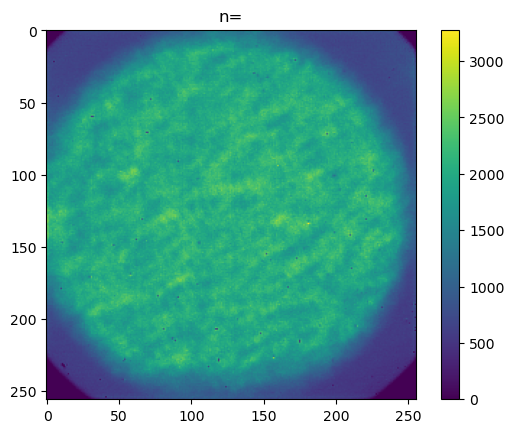

In [58]:
plt.figure()
plt.imshow(canvas)
plt.title(f"n="); plt.colorbar()
plt.show()
imgI=canvas.copy()

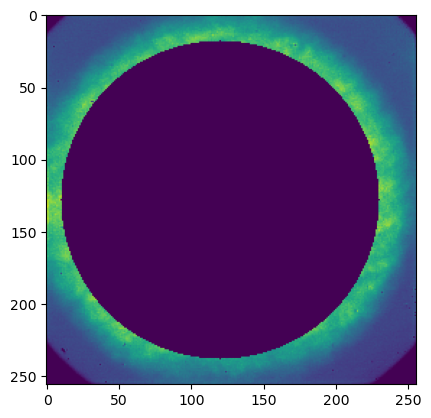

Text(0.5, 1.0, 'normalized image static diffuser')

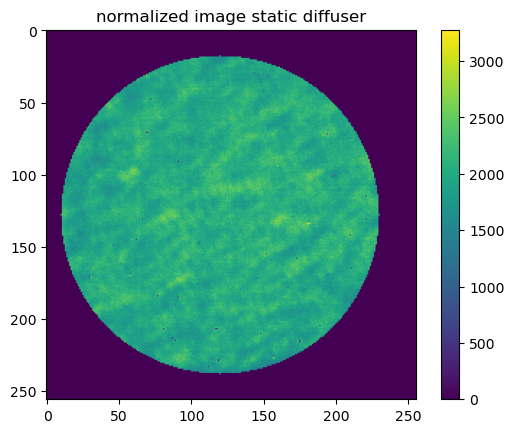

In [62]:
def circle_mask(h=256, w=256, cy=None, cx=None, r=40, filled=True, thickness=1.0):
    cy = h//2 if cy is None else cy
    cx = w//2 if cx is None else cx
    y, x = np.ogrid[:h, :w]
    dist2 = (y - cy)**2 + (x - cx)**2
    out = np.zeros((h, w), dtype=np.uint8)
    if filled:
        out[dist2 <= r*r] = 1
    else:
        out[np.abs(np.sqrt(dist2) - r) <= (thickness/2)] = 1
    return out


h = w = 256
cx=120
cy=128
r = 110

circ_mask = circle_mask(h, w,cx=cx,cy=cy, r=r, filled=True)  # or filled=False for a ring
plt.imshow((1-circ_mask)*imgI)
plt.show()

img_title='static diffuser'

imgIN=imgI
imgIN = imgIN * circ_mask
plt.imshow(imgIN)
plt.title('normalized image ' + img_title)
plt.colorbar()
plt.show()

In [63]:
def plot_complex2(Z, title="Complex 2D Array Visualization"):
    """
    Plot the real part, imaginary part, absolute value, and argument of a 2D complex array.

    Parameters:
        Z (numpy.ndarray): 2D array of complex numbers.
        title (str): Title for the entire figure.
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Real part
    im1 = axes[0, 0].imshow(np.real(Z), cmap='viridis')
    axes[0, 0].set_title("Real Part")
    plt.colorbar(im1, ax=axes[0, 0])

    # Imaginary part
    im2 = axes[0, 1].imshow(np.imag(Z), cmap='plasma')
    axes[0, 1].set_title("Imaginary Part")
    plt.colorbar(im2, ax=axes[0, 1])

    # Magnitude (Absolute Value)
    im3 = axes[1, 0].imshow(np.abs(Z), cmap='inferno')
    axes[1, 0].set_title("Magnitude (Abs)")
    plt.colorbar(im3, ax=axes[1, 0])

    # Phase (Argument)
    im4 = axes[1, 1].imshow(np.log(np.abs(Z)), cmap='twilight')
    axes[1, 1].set_title("Log(Abs)")
    plt.colorbar(im4, ax=axes[1, 1])

    # Global figure title
    fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

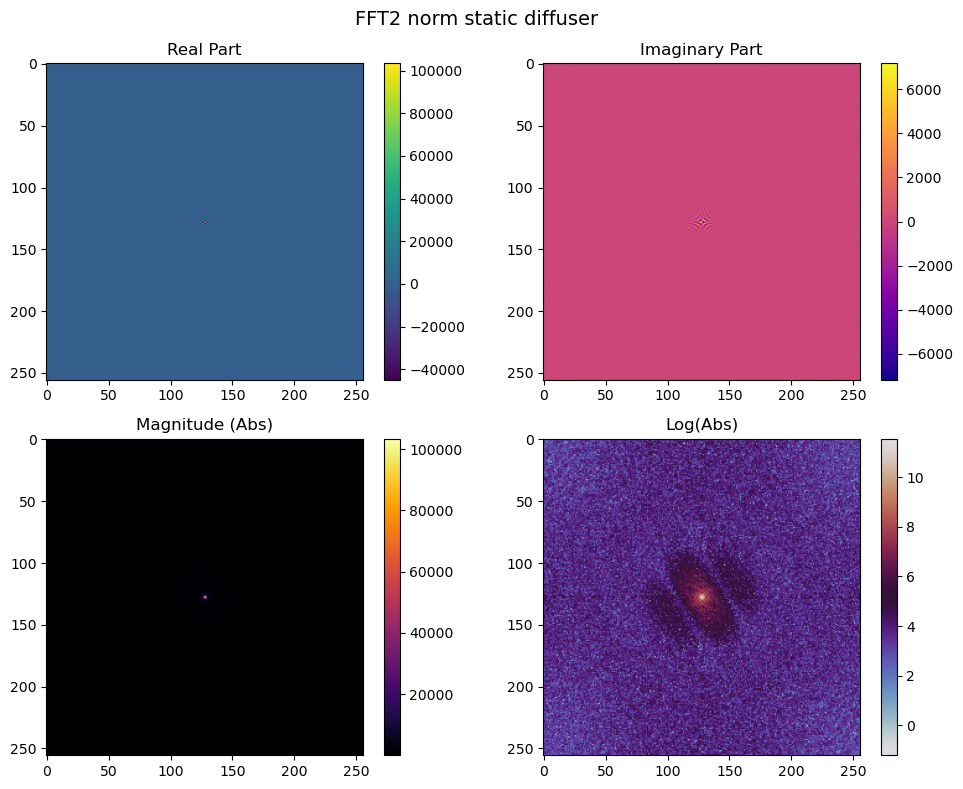

In [64]:
def circular_tukey_window(h=256, w=256, cy=None, cx=None, r=None, alpha=0.2):
    """
    Radialne okno Tukeya: 1 w środku, kosinusowy taper szerokości alpha*r,
    0 poza promieniem r. alpha w [0,1]. cy,cx – środek (y,x).
    """
    cy = h//2 if cy is None else cy
    cx = w//2 if cx is None else cx
    if r is None:
        r = min(cy, cx, h-1-cy, w-1-cx)  # maks. promień mieszczący się w obrazie

    y, x = np.ogrid[:h, :w]
    rho = np.sqrt((y - cy)**2 + (x - cx)**2)

    win = np.zeros((h, w), dtype=np.float32)
    t = alpha * r                          # szerokość strefy wygaszania
    r_flat = r - t

    core = rho <= r_flat                   # część płaska (wartość 1)
    win[core] = 1.0

    taper = (rho > r_flat) & (rho <= r)    # kosinusowe przejście do 0
    win[taper] = 0.5 * (1 + np.cos(np.pi*(rho[taper] - r_flat)/t))

    return win

# ---- użycie ----
# img: Twoja macierz 256x256 (może zawierać NaN poza kołem)
         # ustaw tak, by brzeg okna był tuż przed ostrym brzegiem koła
alpha = 0.2         # 20% promienia to strefa wygaszania


win = circular_tukey_window(h, w, cy, cx, r, alpha)

img=imgIN
# przygotowanie do FFT
img_pre = np.nan_to_num(img, copy=False)   # NaN -> 0 (unikamy ostrych artefaktów)
img_pre = img_pre - np.mean(img_pre)       # odjęcie średniej (DC)

img_w = img_pre * win

# FFT (z przesunięciem zera do środka)
F = np.fft.fftshift(np.fft.fft2(img_w, norm='ortho'))
plot_complex2(F,'FFT2 norm '+img_title)

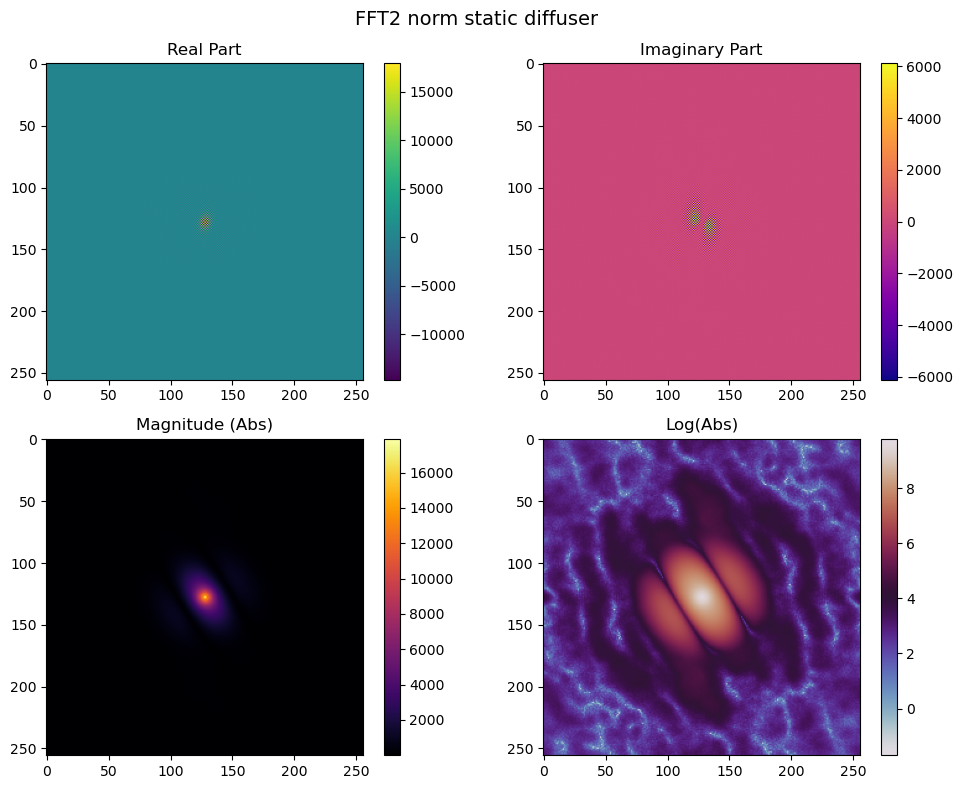

In [51]:
F = np.fft.fftshift(np.fft.fft2(imgIN, norm='ortho'))
plot_complex2(F,'FFT2 norm '+img_title)

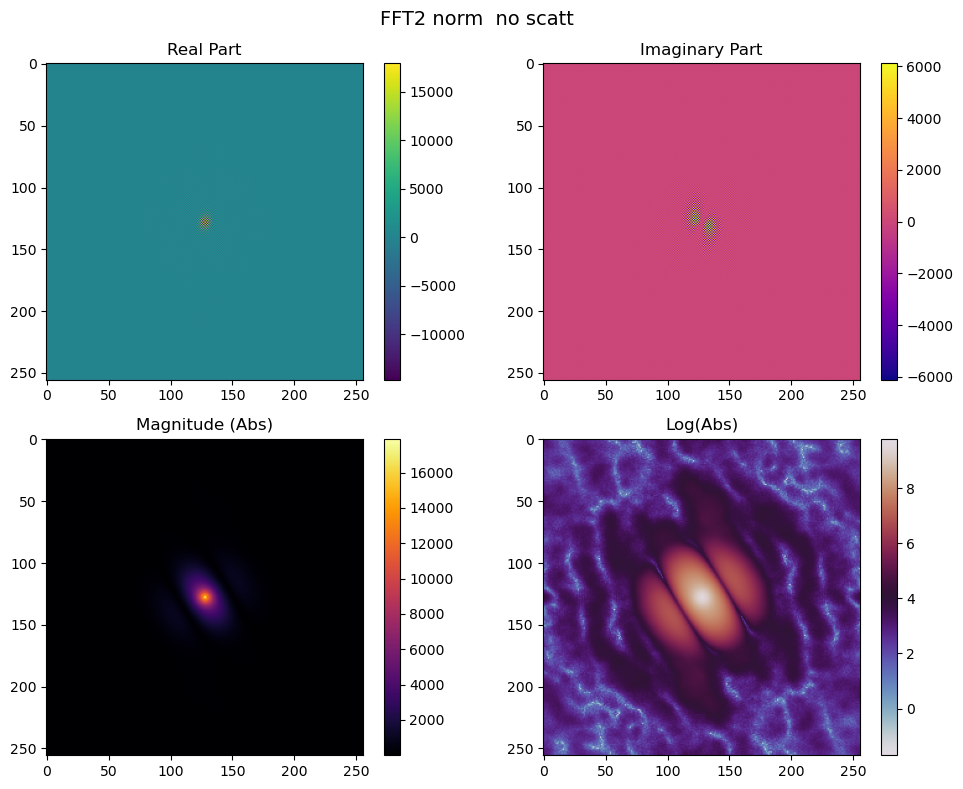

In [54]:
F = np.fft.fftshift(np.fft.fft2(imgIN, norm='ortho'))
plot_complex2(F,'FFT2 norm  no scatt')